<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Week%203/Google%20Colab/Tugas_Week_3_CIFAR_10_Pytorch_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import cycle

from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize


In [3]:
# CIFAR-10 mean dan std untuk normalisasi
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])


In [4]:
# Training set
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Testing set
test_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN Model

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)  # (3, 32, 32) -> (32, 32, 32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                                # -> (32, 16, 16)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)                          # -> (64, 16, 16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                                # -> (64, 8, 8)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)                         # -> (128, 8, 8)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)                                # -> (128, 4, 4)

        self.flatten_dim = 128 * 4 * 4

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.view(-1, self.flatten_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Jangan softmax di sini (nanti di loss)

        return x

In [9]:
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()  # setara dengan sparse_categorical_crossentropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train_model(model, train_loader, test_loader, device, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Tracking
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

        train_acc = 100. * correct / total
        test_acc = evaluate_model(model, test_loader, device)
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    return model


In [11]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100. * correct / total
    return acc

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel()  # dari model yang kamu buat tadi

trained_model = train_model(model, train_loader, test_loader, device, epochs=10, lr=0.001)

Epoch 1: Train Acc: 40.23%, Test Acc: 53.72%


Epoch 2: Train Acc: 54.63%, Test Acc: 62.82%


Epoch 3: Train Acc: 61.16%, Test Acc: 67.00%


Epoch 4: Train Acc: 64.82%, Test Acc: 70.10%


Epoch 5: Train Acc: 67.56%, Test Acc: 72.46%


Epoch 6: Train Acc: 69.23%, Test Acc: 72.77%


Epoch 7: Train Acc: 70.66%, Test Acc: 73.51%


Epoch 8: Train Acc: 71.89%, Test Acc: 75.60%


Epoch 9: Train Acc: 73.00%, Test Acc: 76.53%


Epoch 10: Train Acc: 73.75%, Test Acc: 77.34%


In [15]:
def get_predictions(model, test_loader, device):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

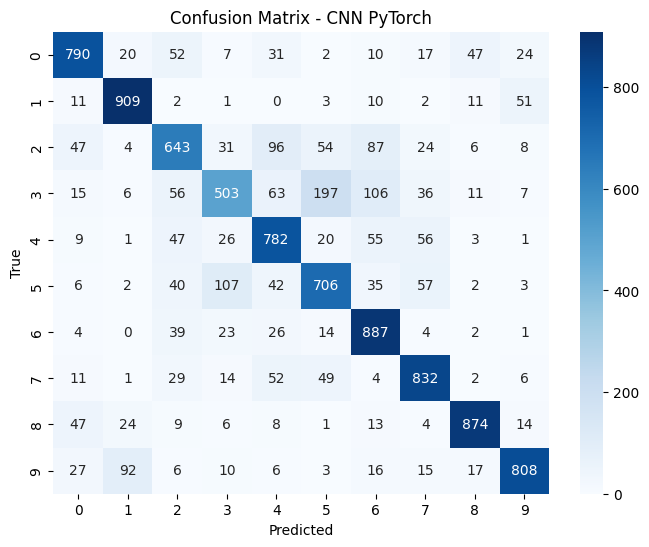


Accuracy: 0.7734
Precision: 0.7735
Recall: 0.7734
F1 Score: 0.7705
ROC AUC Score: 0.9738


In [18]:
# Ambil data dari test loader
y_test, y_pred, y_pred_probs = get_predictions(model, test_loader, device)

# One-hot binarize label asli (buat ROC AUC)
y_test_bin = label_binarize(y_test, classes=np.arange(10))

# Hitung metrik
cnn_acc = accuracy_score(y_test, y_pred)
cnn_precision = precision_score(y_test, y_pred, average='weighted')
cnn_recall = recall_score(y_test, y_pred, average='weighted')
cnn_f1 = f1_score(y_test, y_pred, average='weighted')
cnn_roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasi CM
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - CNN PyTorch")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Cetak hasil evaluasi
print(f"\nAccuracy: {cnn_acc:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall: {cnn_recall:.4f}")
print(f"F1 Score: {cnn_f1:.4f}")
print(f"ROC AUC Score: {cnn_roc_auc:.4f}")

Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


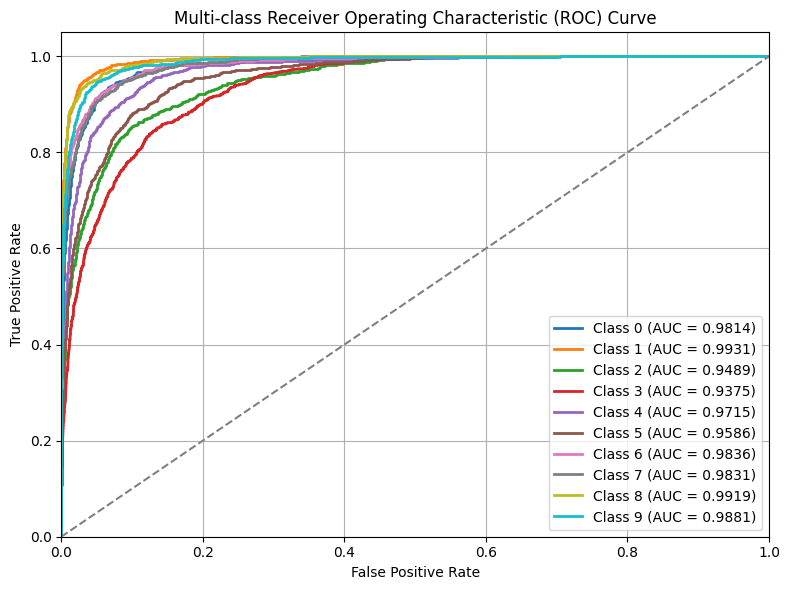

In [22]:
# Jumlah kelas
n_classes = y_pred_probs.shape[1]
print("Unique labels in y_test:", np.unique(y_test))

# One-vs-Rest label
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

colors = cycle(plt.cm.tab10.colors)
plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analisis CNN Model

## 📊 Evaluasi Model CNN PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap setiap kelas (0–9). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 0.7734  
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0.7735  
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0.7734  
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0.7705  
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: 0.9738  
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa cukup baik dengan **akurasi sekitar 77.3%** dan **AUC Score sangat tinggi** (0.9738) menandakan model mampu membedakan antar kelas dengan baik. F1 score juga cukup tinggi, menandakan keseimbangan antara precision dan recall.

Namun, masih ada beberapa kelas yang memiliki nilai prediksi silang cukup tinggi (misclassifications), terutama antara kelas 2, 3, dan 5.

# MLP Model

In [23]:
class MLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten image
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
mlp_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

In [25]:
num_epochs = 10

for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = mlp_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 2.1130
Epoch [2/10], Loss: 2.0259
Epoch [3/10], Loss: 2.0493
Epoch [4/10], Loss: 2.0475
Epoch [5/10], Loss: 2.0522
Epoch [6/10], Loss: 2.0571
Epoch [7/10], Loss: 2.0574
Epoch [8/10], Loss: 2.0668
Epoch [9/10], Loss: 2.0633
Epoch [10/10], Loss: 2.0511


In [26]:
mlp_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = 100. * correct / total

In [27]:
# Ambil prediksi dari MLP
y_test, y_pred, y_pred_probs = get_predictions(mlp_model, test_loader, device)

# Normalisasi probabilitas
y_pred_probs = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)

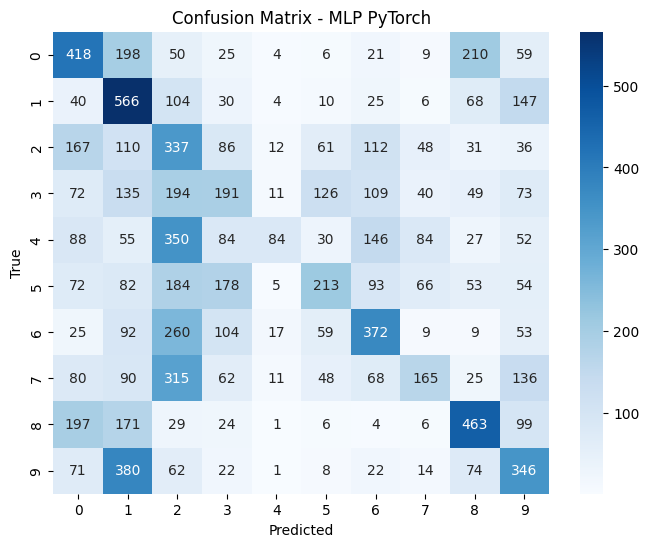


Accuracy: 0.3155
Precision: 0.3531
Recall: 0.3155
F1 Score: 0.3034
ROC AUC Score: 0.7174


In [29]:
# Metrik
mlp_acc = accuracy_score(y_test, y_pred)
mlp_precision = precision_score(y_test, y_pred, average='weighted')
mlp_recall = recall_score(y_test, y_pred, average='weighted')
mlp_f1 = f1_score(y_test, y_pred, average='weighted')
mlp_roc_auc = roc_auc_score(y_test_bin, y_pred_probs, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - MLP PyTorch")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Print hasil metrik ---
print(f"\nAccuracy: {mlp_acc:.4f}")
print(f"Precision: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")
print(f"F1 Score: {mlp_f1:.4f}")
print(f"ROC AUC Score: {mlp_roc_auc:.4f}")

Unique labels in y_test: [0 1 2 3 4 5 6 7 8 9]


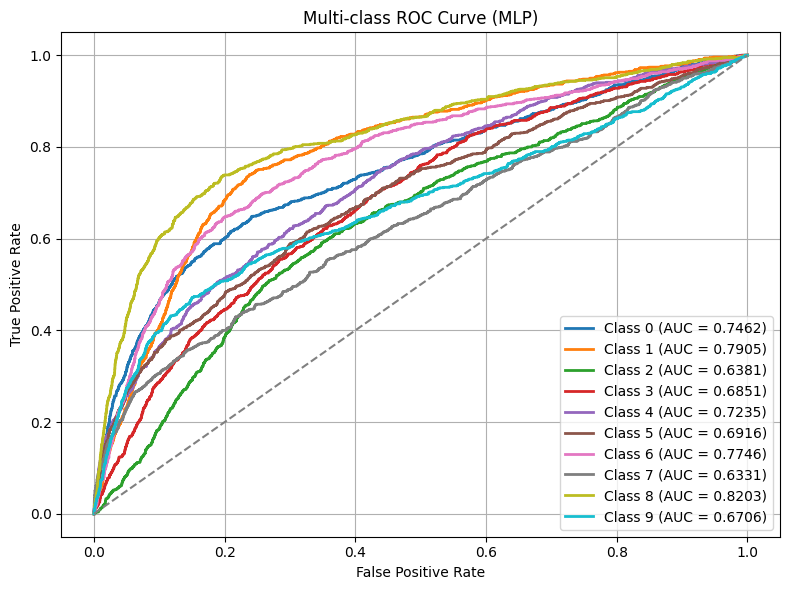

In [30]:
# Jumlah kelas
n_classes = y_pred_probs.shape[1]
print("Unique labels in y_test:", np.unique(y_test))

# One-vs-Rest label
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

colors = cycle(plt.cm.tab10.colors)
plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (MLP)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Analisis MLP Model

## 📊 Evaluasi Model MLP PyTorch

### 🔢 Confusion Matrix
Confusion matrix menunjukkan distribusi prediksi benar dan salah dari model klasifikasi terhadap setiap kelas (0–9). Baris = label sebenarnya, kolom = prediksi model.

### 📈 Metrik Evaluasi
Berikut hasil evaluasi model:

- **Accuracy**: 0.3155  
  $$\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Seluruh Data}}$$

- **Precision**: 0.3531  
  $$\text{Precision} = \frac{TP}{TP + FP}$$
  Precision mengukur seberapa akurat model ketika memprediksi sebuah kelas (menghindari false positives).

- **Recall**: 0.3155
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Recall mengukur seberapa baik model dalam menemukan semua contoh yang benar (menghindari false negatives).

- **F1 Score**: 0.3034  
  $$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$
  Kombinasi harmonis antara precision dan recall.

- **ROC AUC Score**: 0.7174
  ROC AUC menunjukkan performa model dalam membedakan kelas secara keseluruhan. Nilai dekat 1 berarti sangat baik.

### ✅ Kesimpulan
Model ini memiliki performa buruk dengan **akurasi sekitar 31.5%** dan **AUC Score lumayan rendah** (0.7174) menandakan model kurang mampu membedakan antar kelas dengan baik. F1 score juga sangat rendah, menandakan ketidakseimbangan antara precision dan recall.